# Dissimilarity based on topological analysis
Thiele et al. [2016] give an overview of possible representations of the topology in the context of 3D geological modelling. Different levels of complexity (e.g. 1st or 2nd orders ...) can be used. Nonetheless, any topological indicator is a graph, that can take the form of an adjacency matrix. Thus to compute a topological distance between two 3D geological models, it seems natural to look at distances defined between graphs. Donnat & Holmes [2018] provide a comprehensive review of graph distances, used in the study of graph dynamics or temporal evolution. Though, here, in a geological context, we aim at comparing the topological diversity of an ensemble of geological models, we can use similar distances. Donnat & Holmes [2018] classify graph disatnces into three main categories:

### 1. Low-scale distances
On one hand, these distances capture local changes in the graph structure.
 - Hamming distance: sum of absolute value of differences bewteen two adjacency matrices, works for the same number of vertices (nodes) - note that it is a specific case of the more general Graph Edit Distance
 - Jaccard distance: difference between the union and intersection of two graphs
 - Graph Edit Distance: NP-complete class of problems, not computed here. More info available in [Gao et al.,2010], at https://en.wikipedia.org/wiki/Graph_edit_distance, or in Part IV Chapter 15 of the Encyplopediae of Distances [Deza & Deza 2016] p. 301. Some packages and inmplementations exist but have not been tested here:
     - [GMatch4py](https://github.com/Jacobe2169/GMatch4py)
     - [graphkit-learn](https://pypi.org/project/graphkit-learn/) 
     - other heuristic https://hal.archives-ouvertes.fr/hal-01717709/document

### 2. High level / spectral distances
Spectral distances on the other hand are global measures and reflect the smoothness of the overall graph structure changes by measuring dissimilarities in the eigenvalues of the graph Laplacian or its adjacency matrix. Some examples:
 - IM distance [Ipsen and Mikhailov,2002]
 - $l_p$ distances on eigenvalues
 - Kruglov distance ($l_1$?) on eigenvector coordinates [Shimada et al., 2016]

### 3. Meso-scale distances
They are a compromise or combination of low-scale and spectral distances.
 - HIM: Hamming-IM combination
 - Heat-Wave distance
 - polynomial distance
 - neighborhood level distances
 - connectivity-based distances

## What is provided in this notebook
Here, we propose to build first order adjacency matrices from 2D or 3D voxet models. For continuous property fields, the voxet is discretize in $N=10$ classes of values defined by $N$ equi-percentile thresholds over the distribution of the combined voxets. 

We compute two topological distances:
 - structural Hamming distance
 - Laplacian spectral distance [Shimada et al., 2016]

Note that graphs characterizing geological model topology could be defined as attributed graph, to contain more information (edges properties such as age constraint, type of contact; vertices properties such as formation type, geophysical properties). Thus more specific measures could be developed to take into account such characteristics. However, it would rely on the ability of geomodelling engines to provide these topology graphs with each model, and there is no guarantee that it would be useful for the inference of geochronology from geophysical or other observations. 

#### References
Deza, M. M., & Deza, E. (2009). Encyclopedia of distances. In Encyclopedia of distances (pp. 1-583). Springer, Berlin, Heidelberg. https://link.springer.com/content/pdf/10.1007/978-3-642-00234-2_1.pdf

Donnat, C., & Holmes, S. (2018). Tracking network dynamics: A survey using graph distances. The Annals of Applied Statistics, 12(2), 971-1012. https://doi.org/10.1214/18-AOAS1176

Gao, X., Xiao, B., Tao, D., & Li, X. (2010). A survey of graph edit distance. Pattern Analysis and applications, 13(1), 113-129. https://doi.org/10.1007/s10044-008-0141-y

Ipsen, M., & Mikhailov, A. S. (2003). Erratum: Evolutionary reconstruction of networks [Phys. Rev. E 66, 046109 (2002)]. Physical Review E, 67(3), 039901. https://doi.org/10.1103/PhysRevE.67.039901

Shimada, Y., Hirata, Y., Ikeguchi, T., & Aihara, K. (2016). Graph distance for complex networks. Scientific reports, 6(1), 1-6. https://doi.org/10.1038/srep34944

Thiele, S. T., Jessell, M. W., Lindsay, M., Ogarko, V., Wellmann, J. F., & Pakyuz-Charrier, E. (2016). The topology of geology 1: Topological analysis. Journal of Structural Geology, 91, 27-38. https://doi.org/10.1016/j.jsg.2016.08.009

In [1]:
import numpy as np
from datetime import datetime
import pickle
from uncertaintyIndicators import topo_dist

picklefilenametopology = "./pickledata/testing-model-subset-topology.pickle"
picklefilenamedata = "./pickledata/testing-model-subset.pickle"
sample_num1 = 9
sample_num2 = 2

# import data
with open(picklefilenamedata, 'rb') as f:
    [grv_all,mag_all,mod_all,rho_all,sus_all,cmap,samples_ix] = pickle.load(f)

# get dimensions
[nz,ny,nx,nbsamples]=mod_all.shape
nsamples = len(samples_ix) #!nbsamples=nb sub-samples while nsamples=nb noddy models!

# number of classes for discretization of continuous fields
npctiles = 10

## Illustrations
   
### 2D CATEGORICAL VARIABLE

20-Jul-2021 (16:20:11) - COMPUTING 2D 1st order TOPOLOGY IND. LITHOCODE START
unique values in boundaries: [1 4 6]
adjacency matrix: 
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
unique values in boundaries: [1 2 3 4 5 6]
adjacency matrix: 
[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]
litho structural Hamming distance: 0.6
litho Laplacian spectral graph distance: 0.3348755732238678


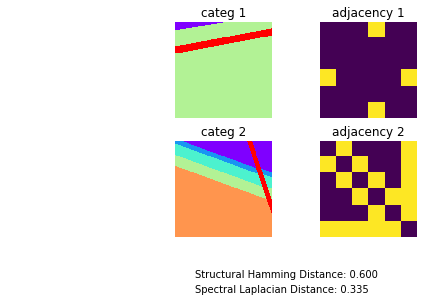

20-Jul-2021 (16:20:12) - COMPUTING 2D 1st order TOPOLOGY IND. LITHOCODE END


In [2]:
#%% 2D CATEGORICAL VARIABLE 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D 1st order TOPOLOGY IND. LITHOCODE START")
img1=np.reshape(mod_all[0,:,:,sample_num1].astype(int),(ny,nx))
img2=np.reshape(mod_all[0,:,:,sample_num2].astype(int),(ny,nx))
# we assume that we are not comparing carrots and potatoes, 
# i.e., that lithocodes values overlap between img1 and img2
# we also assume edge (in 2D) or face (in 3D) type neighborhood
shd_2Dlitho,lsgd2Dlitho = topo_dist(img1, img2, npctiles=0, verb=1, plot=1, leg="litho")
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D 1st order TOPOLOGY IND. LITHOCODE END")

### 2D CONTINUOUS VARIABLE 

20-Jul-2021 (16:20:12) - COMPUTING 2D 1st order TOPOLOGY IND. MAG START
discretize
unique values in boundaries: [3. 4. 5. 6. 7. 8.]
adjacency matrix: 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
unique values in boundaries: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
adjacency matrix: 
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]]
mag structural Hamming distance: 0.4666666666666667
mag Laplacian spectral graph distance: 0.17910040675890

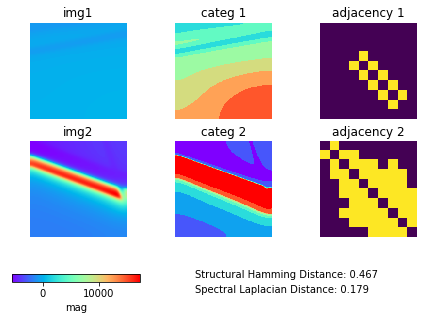

20-Jul-2021 (16:20:12) - COMPUTING 2D 1st order TOPOLOGY IND. MAG END


In [3]:
#%% 2D CONTINUOUS VARIABLE 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D 1st order TOPOLOGY IND. MAG START")
img1=mag_all[:,:,sample_num1]
img2=mag_all[:,:,sample_num2]
shd_2Dmag,lsgd2Dmag = topo_dist(img1, img2, npctiles, verb=1, plot=1, leg="mag")
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D 1st order TOPOLOGY IND. MAG END")

### 3D CATEGORICAL VARIABLE 

20-Jul-2021 (16:20:12) - COMPUTING 3D 1st order TOPOLOGY IND. LITHOCODE START
unique values in boundaries: [1 2 3 4 6]
adjacency matrix: 
[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
unique values in boundaries: [1 2 3 4 5 6]
adjacency matrix: 
[[0. 1. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0.]]
litho structural Hamming distance: 0.26666666666666666
litho Laplacian spectral graph distance: 0.30209704165657264


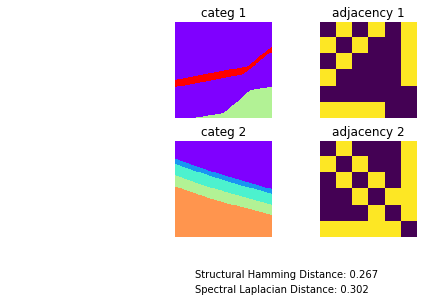

20-Jul-2021 (16:20:15) - COMPUTING 3D 1st order TOPOLOGY IND. LITHOCODE END


In [4]:
#%% 3D CATEGORICAL VARIABLE 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 3D 1st order TOPOLOGY IND. LITHOCODE START")
img1=np.reshape(mod_all[:,:,:,sample_num1].astype(int),(nz,ny,nx))
img2=np.reshape(mod_all[:,:,:,sample_num2].astype(int),(nz,ny,nx))
shd_3Dlitho,lsgd3Dlitho = topo_dist(img1, img2, npctiles=0, verb=1, plot=1, leg="litho")
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 3D 1st order TOPOLOGY IND. LITHOCODE END")

### 3D CONTINUOUS VARIABLE 

20-Jul-2021 (16:20:15) - COMPUTING 3D 1st order TOPOLOGY IND. DENSITY START
discretize
unique values in boundaries: [0. 2. 7. 9.]
adjacency matrix: 
[[0. 1. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]]
unique values in boundaries: [0. 2. 3. 5. 7.]
adjacency matrix: 
[[0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
$\rho$ $kg/m^3$ structural Hamming distance: 0.4666666666666667
$\rho$ $kg/m^3$ Laplacian spectral graph distance: 0.21478914728830323


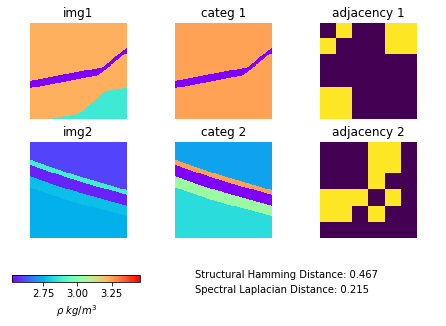

20-Jul-2021 (16:20:22) - COMPUTING 3D 1st order TOPOLOGY IND. DENSITY END


In [5]:
#%% 3D CONTINUOUS VARIABLE 
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 3D 1st order TOPOLOGY IND. DENSITY START")
img1=rho_all[:,:,:,sample_num1]
img2=rho_all[:,:,:,sample_num2]
shd_3Drho,lsgd3Drho = topo_dist(img1, img2, npctiles, verb=1, plot=1, leg="$\\rho$ $kg/m^3$")
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 3D 1st order TOPOLOGY IND. DENSITY END")

## Compute distances for all pairs of voxets<span style='color:red'>\*</span>
<span style='color:red'>**\*WARNING: IT COULD TAKE AROUND 15 MINUTES. PRECOMPUTED RESULTS ALREADY AVAILABLE IN THE PICKLE FOLDER** </span>

In [6]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING TOPOLOGY BASED DIST ALL START")

dist_tpl_shd_mag = np.zeros((nsamples,nsamples))
dist_tpl_shd_grv = np.zeros((nsamples,nsamples))
dist_tpl_shd_mod = np.zeros((nsamples,nsamples))
dist_tpl_shd_rho = np.zeros((nsamples,nsamples))
dist_tpl_shd_sus = np.zeros((nsamples,nsamples))
dist_tpl_lsgd_mag = np.zeros((nsamples,nsamples))
dist_tpl_lsgd_grv = np.zeros((nsamples,nsamples))
dist_tpl_lsgd_mod = np.zeros((nsamples,nsamples))
dist_tpl_lsgd_rho = np.zeros((nsamples,nsamples))
dist_tpl_lsgd_sus = np.zeros((nsamples,nsamples))

k=0
for i in range(nsamples):
    for j in range(i):
        k+=1
        print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+'k = '+str(k)+' - i = '+str(i)+' j = ',str(j))
        dist_tpl_shd_mag[i,j],dist_tpl_lsgd_mag[i,j] = topo_dist(mag_all[:,:,i],mag_all[:,:,j], npctiles)
        dist_tpl_shd_grv[i,j],dist_tpl_lsgd_grv[i,j] = topo_dist(grv_all[:,:,i],grv_all[:,:,j], npctiles)
        dist_tpl_shd_mod[i,j],dist_tpl_lsgd_mod[i,j] = topo_dist(mod_all[:,:,:,i],mod_all[:,:,:,j])
        dist_tpl_shd_rho[i,j],dist_tpl_lsgd_rho[i,j] = topo_dist(rho_all[:,:,:,i],rho_all[:,:,:,j], npctiles)
        dist_tpl_shd_sus[i,j],dist_tpl_lsgd_sus[i,j] = topo_dist(sus_all[:,:,:,i],sus_all[:,:,:,j], npctiles)
        dist_tpl_shd_mag[j,i] = dist_tpl_shd_mag[i,j]
        dist_tpl_shd_grv[j,i] = dist_tpl_shd_grv[i,j]
        dist_tpl_shd_mod[j,i] = dist_tpl_shd_mod[i,j]
        dist_tpl_shd_rho[j,i] = dist_tpl_shd_rho[i,j]
        dist_tpl_shd_sus[j,i] = dist_tpl_shd_sus[i,j]
        dist_tpl_lsgd_mag[j,i] = dist_tpl_lsgd_mag[i,j]
        dist_tpl_lsgd_grv[j,i] = dist_tpl_lsgd_grv[i,j]
        dist_tpl_lsgd_mod[j,i] = dist_tpl_lsgd_mod[i,j]
        dist_tpl_lsgd_rho[j,i] = dist_tpl_lsgd_rho[i,j]
        dist_tpl_lsgd_sus[j,i] = dist_tpl_lsgd_sus[i,j]

print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING TOPOLOGY BASED DIST ALL END")

20-Jul-2021 (16:20:22) - COMPUTING TOPOLOGY BASED DIST ALL START
20-Jul-2021 (16:20:22) - k = 1 - i = 1 j =  0
20-Jul-2021 (16:20:40) - k = 2 - i = 2 j =  0
20-Jul-2021 (16:20:58) - k = 3 - i = 2 j =  1
20-Jul-2021 (16:21:14) - k = 4 - i = 3 j =  0
20-Jul-2021 (16:21:34) - k = 5 - i = 3 j =  1
20-Jul-2021 (16:21:52) - k = 6 - i = 3 j =  2
20-Jul-2021 (16:22:11) - k = 7 - i = 4 j =  0
20-Jul-2021 (16:22:29) - k = 8 - i = 4 j =  1
20-Jul-2021 (16:22:45) - k = 9 - i = 4 j =  2
20-Jul-2021 (16:23:04) - k = 10 - i = 4 j =  3
20-Jul-2021 (16:23:23) - k = 11 - i = 5 j =  0
20-Jul-2021 (16:23:40) - k = 12 - i = 5 j =  1
20-Jul-2021 (16:23:56) - k = 13 - i = 5 j =  2
20-Jul-2021 (16:24:13) - k = 14 - i = 5 j =  3
20-Jul-2021 (16:24:31) - k = 15 - i = 5 j =  4
20-Jul-2021 (16:24:49) - k = 16 - i = 6 j =  0
20-Jul-2021 (16:25:07) - k = 17 - i = 6 j =  1
20-Jul-2021 (16:25:22) - k = 18 - i = 6 j =  2
20-Jul-2021 (16:25:40) - k = 19 - i = 6 j =  3
20-Jul-2021 (16:25:58) - k = 20 - i = 6 j =  4
20-J

## Some Multi-Dimensional Scaling plots<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

20-Jul-2021 (16:40:35) - COMPUTING 2D MDS REPRESENTATION START


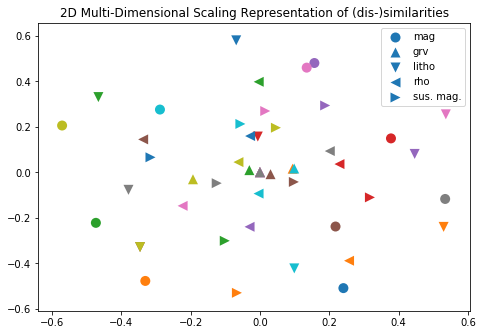

20-Jul-2021 (16:40:39) - COMPUTING 2D MDS REPRESENTATION END


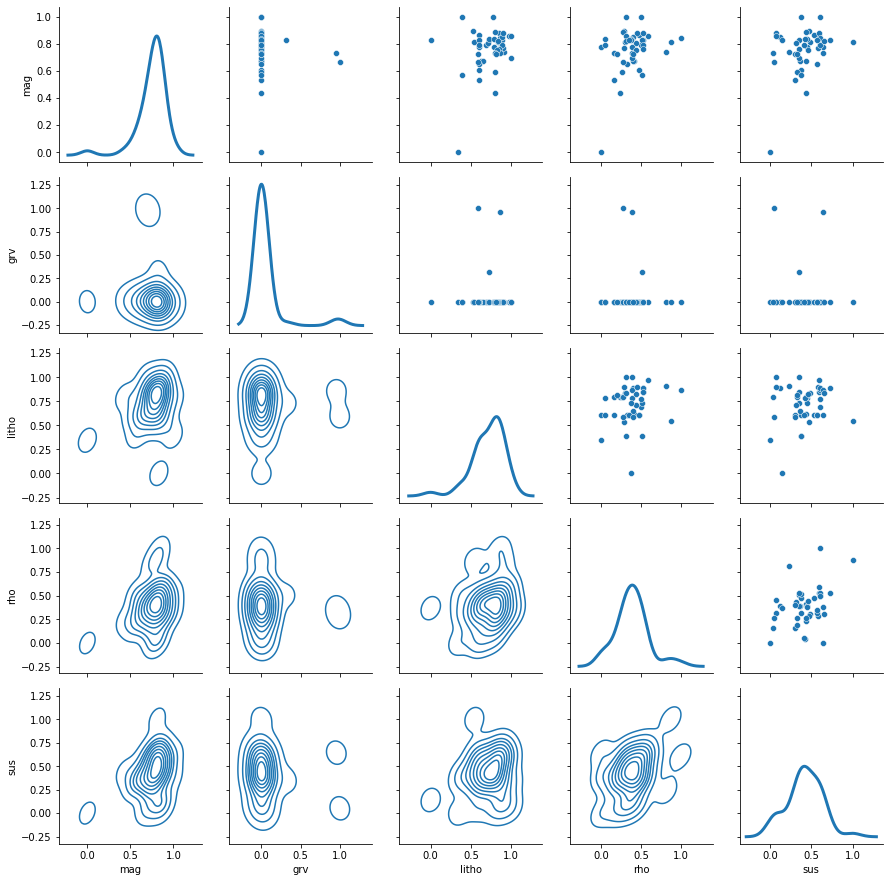

In [11]:
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION START")
from matplotlib import pyplot as plt
from sklearn import manifold
import pandas as pd
import seaborn as sns
myseed = 12345

dist_tpl_lsgd_mag2 = (dist_tpl_lsgd_mag-np.min(dist_tpl_lsgd_mag))/(np.max(dist_tpl_lsgd_mag)-np.min(dist_tpl_lsgd_mag))
dist_tpl_lsgd_grv2 = (dist_tpl_lsgd_grv-np.min(dist_tpl_lsgd_grv))/(np.max(dist_tpl_lsgd_grv)-np.min(dist_tpl_lsgd_grv))
dist_tpl_lsgd_mod2 = (dist_tpl_lsgd_mod-np.min(dist_tpl_lsgd_mod))/(np.max(dist_tpl_lsgd_mod)-np.min(dist_tpl_lsgd_mod))
dist_tpl_lsgd_rho2 = (dist_tpl_lsgd_rho-np.min(dist_tpl_lsgd_rho))/(np.max(dist_tpl_lsgd_rho)-np.min(dist_tpl_lsgd_rho))
dist_tpl_lsgd_sus2 = (dist_tpl_lsgd_sus-np.min(dist_tpl_lsgd_sus))/(np.max(dist_tpl_lsgd_sus)-np.min(dist_tpl_lsgd_sus))

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=myseed,
                    dissimilarity="precomputed", n_jobs=1)

mdspos_mag = mds.fit(dist_tpl_lsgd_mag2).embedding_
mdspos_grv = mds.fit(dist_tpl_lsgd_grv2).embedding_
mdspos_mod = mds.fit(dist_tpl_lsgd_mod2).embedding_
mdspos_rho = mds.fit(dist_tpl_lsgd_rho2).embedding_
mdspos_sus = mds.fit(dist_tpl_lsgd_sus2).embedding_

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])
s = 100
plt.scatter(mdspos_mag[:, 0], mdspos_mag[:, 1], c=np.arange(nsamples),cmap='tab10', s=s, lw=0, label='mag', marker='o')
plt.scatter(mdspos_grv[:, 0], mdspos_grv[:, 1], c=np.arange(nsamples),cmap='tab10', s=s, lw=0, label='grv', marker='^')
plt.scatter(mdspos_mod[:, 0], mdspos_mod[:, 1], c=np.arange(nsamples),cmap='tab10', s=s, lw=0, label='litho', marker='v')
plt.scatter(mdspos_rho[:, 0], mdspos_rho[:, 1], c=np.arange(nsamples),cmap='tab10', s=s, lw=0, label='rho', marker='<')
plt.scatter(mdspos_sus[:, 0], mdspos_sus[:, 1], c=np.arange(nsamples),cmap='tab10', s=s, lw=0, label='sus. mag.', marker='>')
plt.legend(scatterpoints=1, loc='best', shadow=False)
ax.set_title('2D Multi-Dimensional Scaling Representation of (dis-)similarities')
plt.show()

ix=np.tril_indices(nsamples,k=-1)
df= pd.DataFrame({'mag':dist_tpl_lsgd_mag2[ix], 'grv':dist_tpl_lsgd_grv2[ix], 'litho':dist_tpl_lsgd_mod2[ix], 'rho':dist_tpl_lsgd_rho2[ix], 'sus':dist_tpl_lsgd_sus2[ix]})
g = sns.PairGrid(df)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)
print((datetime.now()).strftime('%d-%b-%Y (%H:%M:%S)')+" - "+"COMPUTING 2D MDS REPRESENTATION END")

## Save indicators<span style='color:red'>\*</span>
<span style='color:red'>**\*if all pairs of distances have been computed** </span>

In [ ]:
with open(picklefilenametopology, 'wb') as f:
    pickle.dump([dist_tpl_shd_mag,dist_tpl_shd_grv,dist_tpl_shd_mod,dist_tpl_shd_rho,dist_tpl_shd_sus,
                  dist_tpl_lsgd_mag,dist_tpl_lsgd_grv,dist_tpl_lsgd_mod,dist_tpl_lsgd_rho,
                  dist_tpl_lsgd_sus], f)
